# Business Problem
We are customer satisfaction consultants retained by BaceFook to gauge the community’s reception to new functionality they are adding to their app. While BaceFook has great relationships with their largest enterprise customers, their app is used by individuals across the world. They need a reliable way to understand how individuals and small companies are responding to the new functionality without directly contacting each one.

Our understanding is that the development team feels their new features could be controversial. While they are aimed at making the app more appealing to enterprise customers, there was some concern during the development process that additional options might overwhelm existing users. The company closely monitors new installs of their app, so the impact of new features on new users is something they feel they have a good handle on. As a result, we will limit our review to community response as a whole.

We will use natural language processing on a tweet dataset in order to train our model to recognize emotion expressed in the tweets. Once Bacefook’s new functionality is released, we can feed new tweet information that mentions the app to our model and help the company understand how individuals are receiving the new functionality.


## Todos

Finalize/save off clean data 
- sep notebook?
- stopwords 
- POS Tagging
- Think about train/test split change
- bigrams

From each class:
- word cloud
- example tweets

Address class imbalance
- smote **

pipelines
 - smote? **
 - Vectorizer **
 - transformer **
 - model **
 - KNN **
 - XGBoost
 
Grid Searches
 - RF **
 - GBC **
 
Advanced Modeling
- NN?
- Spacy for class imbalance?

# Questions:
Dummy Classifier is misbehaving. seems like it's always predicting the minority class?

Intuition is maybe we have problems in our data still


# Data Understanding
Our dataset includes 9,092 tweets about multiple brands and products. The tweets were labeled as positive, negative, neutral or not sure by contributors based on the sentiment that the user expressed about the product or products being discussed in the tweet. We elected to drop the 156 “not sure” tweets from our dataset since they accounted for less than 2% of the overall population. Most of the products being discussed are related to mobile devices and applications for those mobile devices, making the data well-suited for training a model on how users express sentiment for these types of products.

The data contains a significant class imbalance, with only 4.5% (411 tweets) classified as negative and only 33% (2,978 tweets) classified as positive. The remaining 62.5% (5,388 tweets) were neutral, which will require us to address class imbalance before running our models. In addition, the dataset is relatively small for a complex problem like sentiment analysis and may be unduly influenced by very active tweeters. 


In [2]:
# Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from pprint import pprint
import nltk
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import MaxNLocator
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import FreqDist
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import tokenize as tok
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import make_scorer

In [3]:
df = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [6]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [7]:
# Dropped the sole blank tweet_text field
df.drop(index=[6], inplace=True)

In [8]:
df['emotion_in_tweet_is_directed_at'].isna().sum()

5801

In [9]:
df["tweet_text"][6520]

"RT @mention RT @mention Can't be at #sxsw? download their free music mix on itunes {link} cc: @mention"

In [10]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [11]:
df_ict = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]

In [12]:
# Dropped the records where sentiment was labeled "I can't tell"
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

#### Preprocessing Data
Effective natural language processing requires significant data modification and cleaning to allow the models to pick up on the meaning of the words they receive. In this section we will define several custom functions to assist with this process, as well as some custom regular expressions to help us filter out meaningless characters that are common in tweets (things like user handles, hashtags, and hyperlinks). We also lemmatized the data in order to avoid duplicate conjugations of words being treated differently by the code, and removed all punctuation.

Finally, we removed stop words from the data. Stop words are common words that appear so frequently in text as to not carry any syntactic meaning. English examples include “the”, “a”, “an”, etc. and were removed using nltk’s built-in stopwords list. There are also several words that appear frequently in each of our three target classes, and as such begin to lose their meaning when training a model. We discuss this further in the Most Common Words section.


In [13]:
# Create column for target variable for easier processing
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [14]:
# Custom regular expressions utilized for cleaning tweet-specific features (retweets, user handles, etc.)
# Credit to Prajwal @ https://gitlab.com/praj88/twitter-analytics/blob/master/scripts/twitter-analytics.ipynb

# Identify hyperlinks in the subject data.
isURL = re.compile(r'http[s]?:// (?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', re.VERBOSE | re.IGNORECASE)

# Identify usernames in retweets.
isRTusername = re.compile(r'^RT+[\s]+(@[\w_]+:)',re.VERBOSE | re.IGNORECASE) #r'^RT+[\s]+(@[\w_]+:)'

# Identify entites preceded by the @ symbol (twitter handles).
isEntity = re.compile(r'@[\w_]+', re.VERBOSE | re.IGNORECASE)

In [15]:
# Function to remove URLs, retweeted usernames and usernames from tweet data.
def clean_tweet(row):
    row = isURL.sub("",row)
    row = isRTusername.sub("",row)
    row = isEntity.sub("",row)
    return row

In [16]:
# Created a new column containing the results of applying the clean_tweet function to the raw data.
df['clean'] = df['tweet_text'].apply(lambda row:clean_tweet(row))

In [17]:
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])  
df['clean'] = df['clean'].str.replace(RE_PUNCTUATION, "")

In [18]:
lemmatizer = WordNetLemmatizer()

def tokenize_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in tok.sent_tokenize(text) for word in tok.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return [lemmatizer.lemmatize(token) for token in filtered_tokens]

In [19]:
df['clean'] = df['clean'].apply(tokenize_lem)

In [20]:
df['clean_joined'] = df['clean'].str.join(" ")

In [21]:
# Create Stopwords list--standard wordlist plus commonly-seen words in the dataset.
sw = stopwords.words('english')
customsw = ['sxsw', 'link', 'rt', 'apple', 'austin', 'google', 'ipad', 'iphone', 'store', 'new', 'app', 'get', 'android']      
             
            #'android', 'social']
            #'get', 'one', 'circle', 'launch', 'line', 'free', 'amp', 'popup', 'ipad2',
            #'like', 'time', 'today']
sw.extend(customsw)

In [22]:

def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_r = [token for token in token_list if token not in sw]
    return stopwords_r

In [23]:
df['clean'] = df['clean'].apply(remove_stopwords)

In [24]:
df['stop_r'] = df['clean'].str.join(" ")

In [25]:
df['stop_r']

0       3g hr tweeting riseaustin wa dead need upgrade...
1       know awesome ipadiphone youll likely appreciat...
2                                          wait also sale
3                     hope year festival isnt crashy year
4       great stuff fri marissa mayer tim oreilly tech...
                              ...                        
9088                                           everywhere
9089    wave buzz interrupt regularly scheduled geek p...
9090    zeiger physician never reported potential ae y...
9091    verizon customer complained time fell back hou...
9092    ï¡ïàüêîò£áââ£âûârt test...
Name: stop_r, Length: 8936, dtype: object

In [26]:
df['clean']

0       [3g, hr, tweeting, riseaustin, wa, dead, need,...
1       [know, awesome, ipadiphone, youll, likely, app...
2                                      [wait, also, sale]
3              [hope, year, festival, isnt, crashy, year]
4       [great, stuff, fri, marissa, mayer, tim, oreil...
                              ...                        
9088                                         [everywhere]
9089    [wave, buzz, interrupt, regularly, scheduled, ...
9090    [zeiger, physician, never, reported, potential...
9091    [verizon, customer, complained, time, fell, ba...
9092    [ï¡ïàüêîò£áââ£âûârt, te...
Name: clean, Length: 8936, dtype: object

#### Most Common Words
In an effort to eliminate noise in our data from words that are common across all classes, we first grouped the data by target class and plotted visualizations of the most frequently-occuring words. When we found that a word appeared in the 10 most common words for each class, we added it to the list of stop words so that it was removed before the modeling process. In the end, we identified a list of 13 words that were so common among each class that they created confusion. These words fell into three distinct categories:
- Brand Names (apple, google, ipad, iphone, android)
- Location of the conference at which classification was performed (austin, sxsw)
- Common terms found in tweets or when referring to mobile applications (link, rt, store, new, app, get).

While meaningful individually, it is easy to understand how these words might lose value when they appear in tweets expressing opposing viewpoints. For example, in the sentences “I love taking pictures on my iphone at sxsw in Austin” and “I hate carrying a huge iphone all over Austin”, the words iphone and austin have very little to do with the emotions being expressed.

In [27]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    

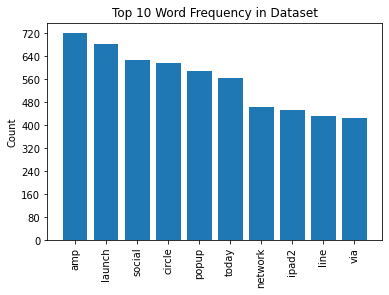

In [28]:
sample_freq_dist = FreqDist(df["clean"].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency in Dataset")

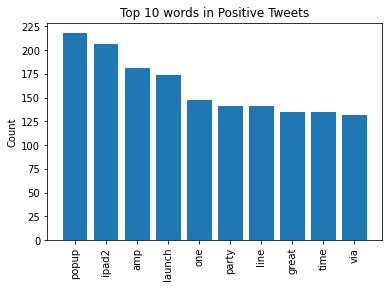

In [29]:
pos_freq_dist = FreqDist(df['clean'].loc[df['target'] == 'Positive emotion'].explode())
visualize_top_10(pos_freq_dist, 'Top 10 words in Positive Tweets')

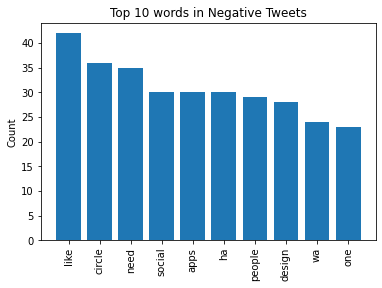

In [30]:
neg_freq_dist = FreqDist(df['clean'].loc[df['target'] == 'Negative emotion'].explode())
visualize_top_10(neg_freq_dist, 'Top 10 words in Negative Tweets')

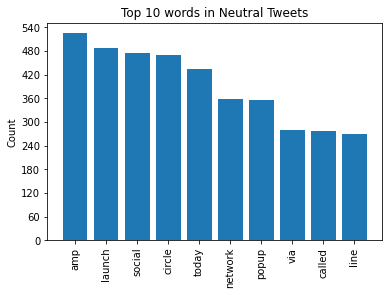

In [31]:
neut_freq_dist = FreqDist(df['clean'].loc[df['target'] == 'No emotion toward brand or product'].explode())
visualize_top_10(neut_freq_dist, 'Top 10 words in Neutral Tweets')

In [32]:
X = df['stop_r']
y = df['target']

In [33]:
type(df['stop_r'][0])

str

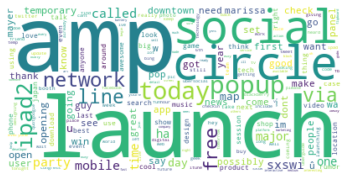

In [38]:
all_text=" ".join(row for row in df.stop_r)
all_wordcloud = WordCloud(collocations=False, background_color='white').generate(all_text) 
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Train Test Split
With our data processing complete, we performed a train-test split on the model using a 30% split between training and test data. We also performed vectorization of our training and test data in order to visualize how the data will be transformed in our pipeline. While we did not utilize these variables any further, it was helpful to visually inspect that the vectorizer worked correctly.


In [39]:
#Performed the train-test split, using 25% for the hold-out data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.30)

In [40]:
tfidf = TfidfVectorizer(max_features=9000)

In [41]:
X_train_vectorized = tfidf.fit_transform(X_train)

In [42]:
X_train_vectorized

<6255x8096 sparse matrix of type '<class 'numpy.float64'>'
	with 48314 stored elements in Compressed Sparse Row format>

In [43]:
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())
X_train_vec

,0310apple,100,100tc,103011p,1045am3,105hrs,10k,10mins,10x,10x2,...,ûïspecial,ûïspecials,ûïthe,ûïwin,ûòand,ûó,ûócan,ûólewis,ûólots,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Transform test data using TF-IDF Vectorizer
X_test_vectorized = tfidf.transform(X_test)
X_test_vectorized

<2681x8096 sparse matrix of type '<class 'numpy.float64'>'
	with 19079 stored elements in Compressed Sparse Row format>

In [45]:
# Convert to DataFrame for visual inspection
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())
X_test_vec

,0310apple,100,100tc,103011p,1045am3,105hrs,10k,10mins,10x,10x2,...,ûïspecial,ûïspecials,ûïthe,ûïwin,ûòand,ûó,ûócan,ûólewis,ûólots,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling
For our analysis, we elected to use accuracy score to evaluate our models. Our goal is to correctly categorize each tweet into positive, negative or neutral based on its contents. The multiclass nature of the problem makes it more challenging for the model to accurately predict sentiment. However, we chose accuracy as our evaluation metric because it evaluates how many of the model’s predictions are correct. The impact of a false negative or false positive prediction is less severe in this business case than in medical diagnosis, for example. Assuming that the accuracy performance of the model is good enough, the company should be able to use it to form a reasonable understanding of how the wider community is receiving their releases. It will be less suited for predicting the same for individual users, but that is not the goal of this analysis.

For each model we created a pipeline that includes a TF-IDF vectorizer, a smote component to deal with class imbalance, and the classifier itself. We elected to use a TF-IDF vectorizer instead of a count vectorizer because it provides a way to understand the importance of each word to the tweet, as well as just how frequently it occurs. 


In [108]:
# Define max features for all models
max_features = 7000

In [109]:
# Customer scorers using the weighted average argument, to be used in cross-validation

# Accuracy
accuracy = accuracy_score

#f1
custom_f1 = make_scorer(
    f1_score, 
    average="weighted"
)

# Precision
multi_prec = make_scorer(
    precision_score,
    average="weighted")

# Recall
multi_rec = make_scorer(
    recall_score,
    average="weighted")

# This function will allow for quick cross-validation of the chosen score for each of our models.
def cross_val(model, X, y, custom_scorer, kfolds=5):
    """ Perform cross-validated scoring and store/print results """
    results = cross_val_score(model, X, y, cv=kfolds, scoring=custom_scorer)
    mean = np.mean(results)
    median = np.median(results)
    std = np.std(results)
    if custom_scorer == custom_f1:
        print(f"Mean f1 score: ", {mean}, ".")
        print(f"Median f1 score: ", {median}, ".")
        print(f"Standard Deviation in f1 score: ", {std}, ".") 
    elif custom_scorer == multi_prec:
        print(f"Mean precision score: ", {mean}, ".")
        print(f"Median precision score: ", {median}, ".")
        print(f"Standard Deviation in precision score: ", {std}, ".") 
    elif custom_scorer == multi_rec:
        print(f"Mean recall score: ", {mean}, ".")
        print(f"Median recall score: ", {median}, ".")
        print(f"Standard Deviation in recall score: ", {std}, ".") 

### Dummy Classifier

In [110]:
# Instantiate Dummy Classifier pipeline
dummy_pipe = ImPipeline(steps=[
                                    ('vect', TfidfVectorizer(max_features=max_features)),
                                    ('sm', SMOTE(random_state=42)),
                                    ('dc', DummyClassifier(strategy='constant', constant='No emotion toward brand or product',
                                                           random_state=42))
                                    ]
                            )

0.3644259907821145
0.6036770583533173


/Users/tom/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


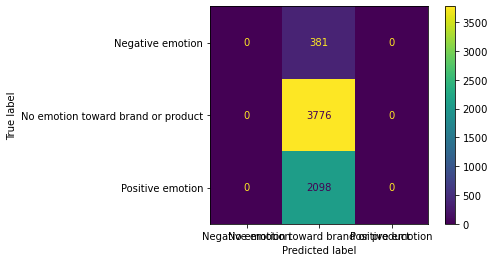

In [111]:
# Fit dummy pipe on the training data, get predictions and plot confusion matrix
dummy_pipe.fit(X_train, y_train)
dummy_yhat = dummy_pipe.predict(X_train)
plot_confusion_matrix(dummy_pipe, X_train, y_train)
print(precision_score(y_train, dummy_yhat, average='weighted'))
print(accuracy_score(y_train, dummy_yhat))

In [112]:
print(classification_report(y_train, dummy_yhat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00       381
No emotion toward brand or product       0.60      1.00      0.75      3776
                  Positive emotion       0.00      0.00      0.00      2098

                          accuracy                           0.60      6255
                         macro avg       0.20      0.33      0.25      6255
                      weighted avg       0.36      0.60      0.45      6255



/Users/tom/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
# Obtained cross-validated score
print(cross_val(dummy_pipe, X_train, y_train, multi_prec))

acc_score = cross_val_score(dummy_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

/Users/tom/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean precision score:  {0.36442609301847095} .
Median precision score:  {0.3642329941003232} .
Standard Deviation in precision score:  {0.00038619783629532104} .
None
Mean Accuracy Score:  0.6036770583533173 .


### FSM - Logistic Regression

0.863048942531813

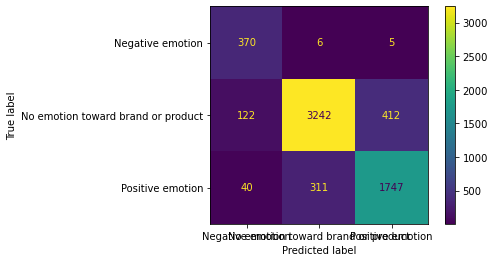

In [114]:
# Instantiate the Logistic Regression Pipeline
logreg_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('lr', LogisticRegression(max_iter=1000))
                                ]
                        )


# Fit Logistic Regression pipeline on the training data, get predictions and plot confusion matrix
logreg_pipe.fit(X_train, y_train)
logreg_y_hat = logreg_pipe.predict(X_train)
plot_confusion_matrix(logreg_pipe, X_train, y_train)
precision_score(y_train, logreg_y_hat, average='weighted')

In [115]:
# Obtained cross-validated score
cross_val(logreg_pipe, X_train, y_train, multi_prec)

Mean precision score:  {0.6598273681571802} .
Median precision score:  {0.6541371761646035} .
Standard Deviation in precision score:  {0.016752727707866726} .


In [116]:
acc_score = cross_val_score(logreg_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.649400479616307 .


### Multinomial Naive Bayes

In [117]:
# Instantiate the MNB Pipeline
mnb_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('mnb', MultinomialNB())
                                ]
                        )

0.8268628948035088

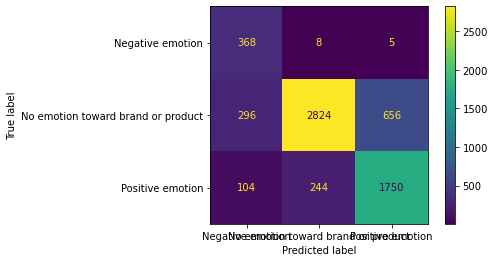

In [118]:
# Fit Multinomial Naive Bayes pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X_train, y_train)
mnb_y_hat = mnb_pipe.predict(X_train)
plot_confusion_matrix(mnb_pipe, X_train, y_train)
precision_score(y_train, mnb_y_hat, average='weighted')

In [119]:
print(classification_report(y_train, mnb_y_hat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.48      0.97      0.64       381
No emotion toward brand or product       0.92      0.75      0.82      3776
                  Positive emotion       0.73      0.83      0.78      2098

                          accuracy                           0.79      6255
                         macro avg       0.71      0.85      0.75      6255
                      weighted avg       0.83      0.79      0.80      6255



In [120]:
# Obtained cross-validated score
print(cross_val(mnb_pipe, X_train, y_train, multi_prec))

acc_score = cross_val_score(mnb_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean precision score:  {0.6526116571176518} .
Median precision score:  {0.6475462848350548} .
Standard Deviation in precision score:  {0.012925151653691446} .
None
Mean Accuracy Score:  0.597761790567546 .


### Linear Support Vector

In [121]:
# Instantiate Linear Support Vector Pipeline
lsv_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('lsv', SGDClassifier(random_state=42))
                                ]
                        )

0.868893969908916

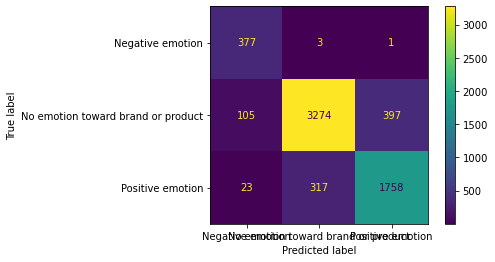

In [122]:
# Fit linear support vector machine on the training data, get predictions and plot confusion matrix
lsv_pipe.fit(X_train, y_train)
lsv_y_hat = lsv_pipe.predict(X_train)
plot_confusion_matrix(lsv_pipe, X_train, y_train)
precision_score(y_train, lsv_y_hat, average='weighted')

In [123]:
# Obtained cross-validated score
#cross_val(lsv_pipe, X_train, y_train, multi_prec)

In [124]:
acc_score = cross_val_score(lsv_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.6500399680255796 .


### K-Nearest Neighbors

In [125]:
# Instantiate K-Nearest Neighbors pipeline
knn_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('knn', KNeighborsClassifier())  
                                ]
                        )

0.7914757966929974

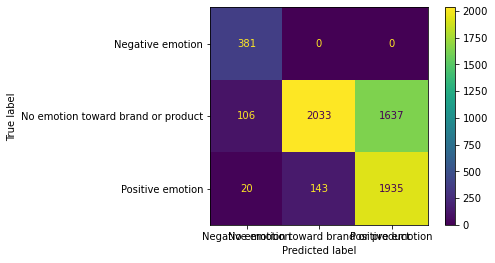

In [126]:
# Fit KNN pipeline on the training data, get predictions and plot confusion matrix
knn_pipe.fit(X_train, y_train)
knn_yhat = knn_pipe.predict(X_train)
plot_confusion_matrix(knn_pipe, X_train, y_train)
precision_score(y_train, knn_yhat, average='weighted') 

In [127]:
# Obtained cross-validated score
#cross_val(knn_pipe, X_train, y_train, multi_prec)

In [128]:
acc_score = cross_val_score(knn_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.5507593924860112 .


### Gradient Boosted Classifier

In [129]:
# Instantiate the pipeline
gbc_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('gbc',  GradientBoostingClassifier())
                                ]
                        )

0.7121991854079679

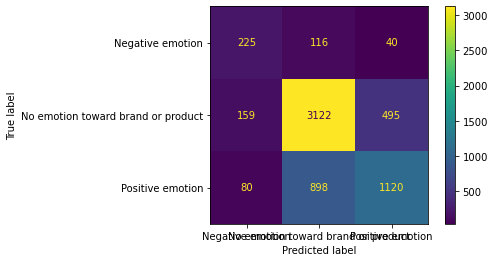

In [130]:
# Fit gradient boosted pipeline on the training data, get predictions and plot confusion matrix
gbc_pipe.fit(X_train, y_train)
gbc_yhat = gbc_pipe.predict(X_train)
plot_confusion_matrix(gbc_pipe, X_train, y_train)
precision_score(y_train, gbc_yhat, average='weighted') 

In [131]:
# Obtained cross-validated score
#cross_val(gbc_pipe, X_train, y_train, multi_prec)

In [132]:
acc_score = cross_val_score(gbc_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.6455635491606714 .


### RF Classifier

In [133]:
# Instantiate Random Forest pipeline
rf_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('rf', RandomForestClassifier(
                                 #    bootstrap= True,
                                 #    criterion='gini',
                                 #    max_depth=200,
                                 #    min_samples_leaf=1,
                                 #    min_samples_split=5,
                                 #    n_estimators=250,
                                     random_state=42))
                                ]
                        )

0.9627596666975123

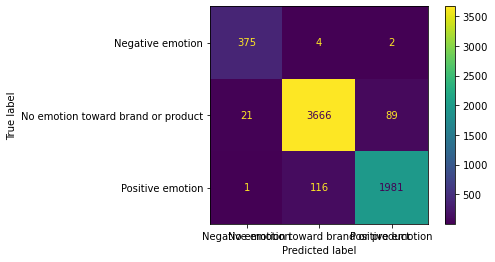

In [134]:
# Fit random forest pipeline on the training data, get predictions and plot confusion matrix
rf_pipe.fit(X_train, y_train)
rfp_yhat = rf_pipe.predict(X_train)
plot_confusion_matrix(rf_pipe, X_train, y_train)
precision_score(y_train, rfp_yhat, average='weighted') 

In [135]:
print(classification_report(y_train, rfp_yhat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.94      0.98      0.96       381
No emotion toward brand or product       0.97      0.97      0.97      3776
                  Positive emotion       0.96      0.94      0.95      2098

                          accuracy                           0.96      6255
                         macro avg       0.96      0.97      0.96      6255
                      weighted avg       0.96      0.96      0.96      6255



In [136]:
# Obtained cross-validated score
# cross_val(rf_pipe, X_train, y_train, multi_prec)

In [137]:
acc_score = cross_val_score(rf_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.6740207833733013 .


#### Gridsearch--Random Forest

In [138]:
# Print out original parameters of rf classifier in rf_pipe
print('Current Parameters:\n')
pprint(rf_pipe.named_steps['rf'].get_params())

Current Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [139]:
# Define new set of parameters to grid-search over
rf_params = {
            'rf__n_estimators': [100, 250, 500, 1000],
            'rf__criterion': ['gini', 'entropy'],
            'rf__min_samples_leaf': [1, 2, 3],
            'rf__min_samples_split': [2, 4, 5, 6],
            'rf__max_depth': [100, 200, 300],
            'rf__bootstrap': [True, False],
            'vect__max_features': [None, 2000, 4000, 5000, 6000, 7000]
             }

# Instantiate grid search object using parameters defined above.
#rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, n_jobs=-2, verbose=3, cv=3)

# Fit the grid search object on training data
#rf_gs.fit(X_train, y_train)

# Output the best parameters based on the grid search
#rf_gs.best_params_

gridsearch 1 output: 
- {'rf__bootstrap': True,
- 'rf__criterion': 'entropy',
- 'rf__max_depth': None,
- 'rf__min_samples_leaf': 1,
- 'rf__min_samples_split': 5,
- 'rf__n_estimators': 250,
- 'vect__max_features': None}

rf_params = {
            'rf__n_estimators': [200, 250, 300],
            'rf__criterion': ['gini', 'entropy'],
            'rf__min_samples_leaf': [1, 2],
            'rf__min_samples_split': [4, 5, 6],
            'rf__max_depth': [None, 100, 150, 200],
            'rf__bootstrap': [True, False],
            'vect__max_features': [None, 6000, 8000]
             }

grid search 2 output:
- {'rf__bootstrap': True,
- 'rf__criterion': 'gini',
- 'rf__max_depth': 200,
- 'rf__min_samples_leaf': 1,
- 'rf__min_samples_split': 6,
- 'rf__n_estimators': 250,
- 'vect__max_features': 6000}s

rf_params = {
            'rf__n_estimators': [225, 250, 275],
            'rf__criterion': ['gini', 'entropy'],
            'rf__min_samples_leaf': [1, 2],
            'rf__min_samples_split': [5, 6, 7],
            'rf__max_depth': [150, 200, 300],
            'rf__bootstrap': [True, False],
            'vect__max_features': [5000, 6000, 7000]
             }

grid search 3 output:
- {'rf__bootstrap': True,
- 'rf__criterion': 'gini',
- 'rf__max_depth': 200,
- 'rf__min_samples_leaf': 1,
- 'rf__min_samples_split': 5,
- 'rf__n_estimators': 250,
- 'vect__max_features': 5000}

rf_params = {
            'rf__n_estimators': [240, 250, 260],
            'rf__criterion': ['gini', 'entropy'],
            'rf__min_samples_leaf': [1, 2],
            'rf__min_samples_split': [4, 5, 6],
            'rf__max_depth': [190, 200, 210],
            'rf__bootstrap': [True, False],
            'vect__max_features': [None, 4500, 5000, 5500, 6000]
             }

grid search 4 output:
- {'rf__bootstrap': True,
- 'rf__criterion': 'gini',
- 'rf__max_depth': 200,
- 'rf__min_samples_leaf': 1,
- 'rf__min_samples_split': 5,
- 'rf__n_estimators': 250,
- 'vect__max_features': 5000}

rf_params = {
            'rf__n_estimators': [100, 250, 500, 1000],
            'rf__criterion': ['gini', 'entropy'],
            'rf__min_samples_leaf': [1, 2, 3],
            'rf__min_samples_split': [2, 4, 5, 6],
            'rf__max_depth': [100, 200, 300],
            'rf__bootstrap': [True, False],
            'vect__max_features': [None, 2000, 4000, 5000, 6000, 7000]
             }


grid search 5 output:
    {'rf__bootstrap': True,
 'rf__criterion': 'gini',
 'rf__max_depth': 200,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 250,
 'vect__max_features': 5000}

# Final Model & Evaluation

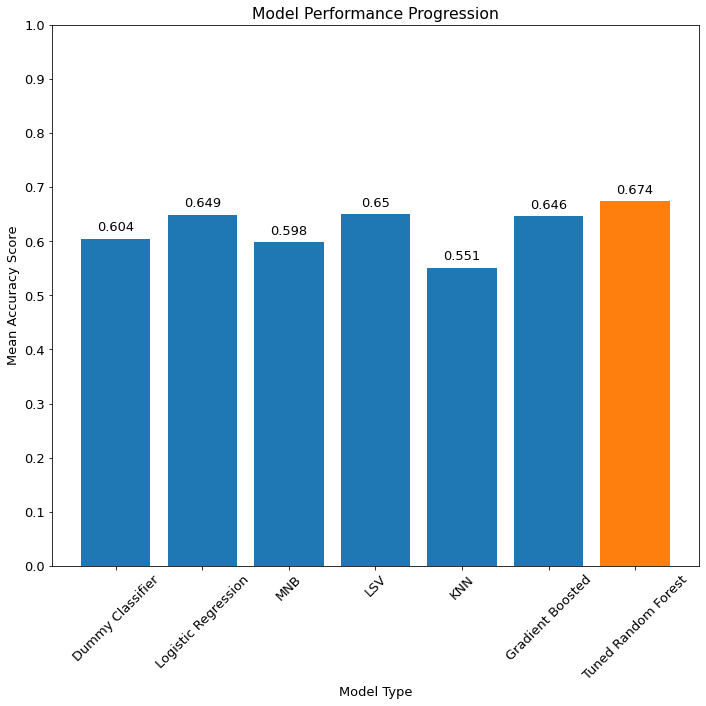

In [145]:
# Create dictionary of models and cross-val scores
model_its = {'Dummy Classifier':0.604, 'Logistic Regression':0.649, 'MNB':0.598, 'LSV': 0.65, 'KNN':0.551, 'Gradient Boosted':0.646, 'Tuned Random Forest':0.674}

# Plot bar graph using model_its dictionary
plt.rcParams.update({'font.size': 13});
colors = ["C1" if i > 0.66 else 'C0' for i in model_its.values()]
fig, ax = plt.subplots(figsize=(10,10))
pps = plt.bar(x = model_its.keys(), height=model_its.values(), color=colors)

plt.xlabel('Model Type')
plt.ylabel('Mean Accuracy Score')
plt.title('Model Performance Progression')
plt.xticks(rotation = 45)
plt.yticks(np.arange(0, 1.1, step=0.1))

# Assign score values to each bar in the graph
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 5), # 3 points vertical offset
      textcoords="offset points",  
      ha='center', va='bottom')
plt.tight_layout();

plt.savefig('../images/mod_perf', facecolor='white', dpi=500)

# Conclusion & Next Steps


Given additional time and resources, we would like to explore the following additional avenues:
- Deploy pre-trained NLP model & train on the data set
- Increase the size of the dataset to include tweets regarding other brands of mobile device or application
- Develop a data pipeline to intake all new tweets that mention the company over a given time period and continue training the model on new data. New tweets are introduced quite frequently while the company’s release schedule is sporadic. We will gain additional insight by adding new training data to the dataset.


# Recommendations